# **Modelling developer profiles**
-------------------------------------------

## *TAED2, GCED, UPC BarcelonaTech*
#### *Jesus Antonanzas, Cristina Aguilera, Laia Albors, Sonia Rabanaque*
#### *16-10-2020*
------------------------------------------

# 0. Objectives and procedure
This notebook consists in the modeling of the clean, prepared TechDebt dataset, with objective of extracting meaningful clusters that group developer profiles. The structure is as follows:

1. **Simple Feature Selection**: we try to filter features that are not relevant.
2. **Clustering (with PCA)**:  
  2.1. **Dimensionality Reduction with PCA**: meaningful 'Principal Components' are extracted from the data and an appropiate number of them is selected.  
  2.2. **KMeans over PCA**: we fit a clustering model over the data projected onto the selected principal components. We also try to pick an appropiate number of clusters.  
  2.3. **Explaining the clusters (with PCA)**: we try to relate the clusters found in 2.2. (which were in the 'Principal Component' space) to the original features.
3. **Clustering (with tSVD)**: with the same subsections as section 2, but having reduced the dimensionality of the data with Truncated SVD instead of PCA.

As output, we have extracted two CSV files containing the mean characteristics of each developer cluster extracted from sections 2 and 3 to power analyses in the next project step (Evaluation).

Note that we have allowed for reproducible results setting random states as constants. 

In [6]:
!pip install altair

In [7]:
from sklearn import cluster, decomposition, preprocessing, feature_selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import altair as alt

Ingest from the previous 'Data Preparation' step.

In [8]:
devs = pd.read_csv('../../data/processed/DEVELOPERS_DATA.csv')

In [9]:
devs.describe()

,Unnamed: 0,numberCommits,fixedSZZIssues,fixedSonarIssues,fixedJiraIssues,inducedSZZIssues,inducedSonarIssues,timeInProject,resolutionTime,jiraBug,...,codeSecurityRemediationEffort,sonarDebt,sonarCloseTime,sonarBug,sonarCodeSmell,sonarVulnerability,sonarBlocker,sonarCritical,sonarInfo,sonarMajor
count,2460.000000,2460.00000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2.460000e+03,2460.000000,2460.000000,...,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000,2460.000000
mean,1229.500000,57.17561,3.470732,6.293902,18.964228,0.271545,7.814228,1.662980e+07,5487.654053,11.496748,...,66.817073,203.145705,5189.473071,7.682520,595.684959,19.313008,5.756504,47.157724,14.806911,319.979675
std,710.285154,288.53359,26.025990,39.785509,86.742777,2.182839,50.255282,4.410435e+07,11647.773387,60.811100,...,1153.072760,3547.579331,16731.385667,133.585483,10372.283059,430.049277,170.966172,911.751724,334.961268,5556.044133
min,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,-3965.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,614.750000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1229.500000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000e+00,430.138474,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1844.250000,6.00000,0.000000,0.000000,5.000000,0.000000,0.000000,4.171151e+06,4881.491597,2.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2459.000000,5627.00000,560.000000,945.000000,1557.000000,61.000000,1542.000000,4.130488e+08,99715.946667,1531.000000,...,47210.000000,119858.883333,155108.603611,5425.000000,405060.000000,19973.000000,8333.000000,38278.000000,12382.000000,219671.000000


In [10]:
len(devs)

2460

# 1. Simple feature selection

We try to select features that are most important in the dataset. First, though, we need to normalize the attributes.

In [11]:
minMaxScaler = preprocessing.MinMaxScaler()
devsScaled = minMaxScaler.fit_transform(devs.drop(['committer', 'Unnamed: 0'], axis=1))

Let's try to perform simple feature selection:

In [12]:
# Variance selection, the same % of variability that the first 9 PCA components accounted for.
featureSelector = feature_selection.VarianceThreshold()
res = featureSelector.fit_transform(devsScaled)
len(res[0])

93

Only removes one feature, meanining that almost all of them account for some variance. Moreover, if we try to delete features that account for less than say 5% of variance:

In [13]:
featureSelector = feature_selection.VarianceThreshold(threshold=0.05)
featureSelector.fit_transform(devsScaled)

ValueError: No feature in X meets the variance threshold 0.05000

(intended to fail) Not 1 feature does so, which means that each of the other 83 features accounts for less than 5% of variance. So, no feature selection will be good enough here.

With 83 features, it is difficult to cluster appropiately because of the 'curse of dimensionality' and because euclidian distance diverges (and it's the distance used in many popular clustering techniques), among other reasons. We need to somehow reduce the feature space.

# 2. Dimensionality reduction with PCA

We picked PCA because of its simplicity and interpretable results. That is, it looks for orthonormal vectors ('Principal Components' or 'PCs') from linear relations between the data features that maximize the variance.

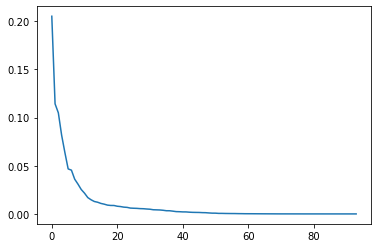

In [14]:
pca = decomposition.PCA(random_state=888)
devPCA = pca.fit(devsScaled)
comps = devPCA.components_
compsVariance = devPCA.explained_variance_
compsVarRatio = devPCA.explained_variance_ratio_

plt.plot(compsVarRatio)

In [15]:
# Pick components that account for x% of variability
cumSum = 0
nComps = 0
x = 0.75
for varExplained in compsVarRatio:
  cumSum += varExplained
  if cumSum >= x:
    break
  else:
    nComps += 1
print(nComps)

9


Thus, 9 components explain 75% of variability in our data

In [16]:
projectedPoints = devPCA.transform(devsScaled)
importantDims = projectedPoints[:,:9]

# 2.1. Clustering over the Principal Components

Let us find an appropiate number of clusters.

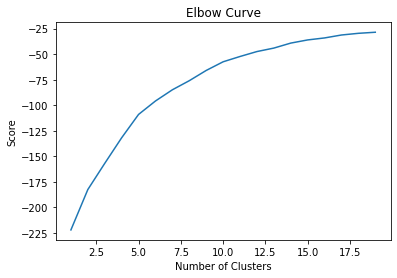

In [17]:
Nc = range(1, 20)
kmeans = [cluster.KMeans(n_clusters=i, random_state=888) for i in Nc]
kmeans
score = [kmeans[i].fit(importantDims).score(importantDims) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

5 or 6 clusters seem appropiate (we approximately look for the number of clusters that serves as an elbow point in the curve).   
From [Wikipedia](https://en.wikipedia.org/wiki/Elbow_method_(clustering)#:~:text=In%20cluster%20analysis%2C%20the%20elbow,clusters%20in%20a%20data%20set.&text=The%20same%20method%20can%20be,to%20describe%20a%20data%20set): 'Using the "elbow" or "knee of a curve" as a cutoff point is a common heuristic in mathematical optimization to choose a point where diminishing returns are no longer worth the additional cost.'

In [18]:
def fitKMeansAndPlot(data, nClusters=3):
  """
  Fits the data to a KMeans model and plots the result over the principal 
  components that explain the most variance.
  """
  kmeans = cluster.KMeans(n_clusters=nClusters, random_state=888)
  fittedKMeans = kmeans.fit(importantDims) 
  centroids = kmeans.cluster_centers_
  labels = kmeans.predict(importantDims)

  colors=['red', 'green', 'blue', 'yellow', 'black', 'gray']
  colors = colors[:nClusters]
  toAsign=[]
  for row in labels:
      toAsign.append(colors[row])

  fig = plt.figure()
  ax = Axes3D(fig)
  ax.scatter(importantDims[:, 0], importantDims[:, 1], importantDims[:, 2], c=toAsign,s=60)
  ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], marker='*', c=colors, s=1000)

  return labels, kmeans

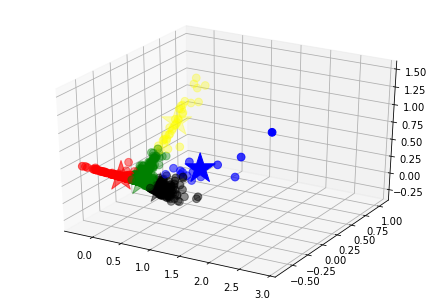

In [19]:
labels, kmeans = fitKMeansAndPlot(importantDims, nClusters=5)

In [20]:
nLabels = dict()
for label in labels:
  if label not in nLabels:
    nLabels[label] = 1
  nLabels[label] += 1 
print(nLabels)

{1: 1950, 4: 239, 2: 15, 3: 36, 0: 225}


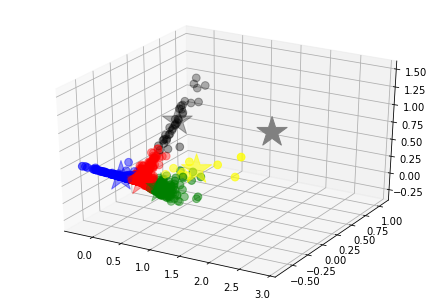

In [21]:
labels, kmeans = fitKMeansAndPlot(importantDims, nClusters=6)

In [22]:
nLabels = dict()
for label in labels:
  if label not in nLabels:
    nLabels[label] = 1
  nLabels[label] += 1 
print(nLabels)

{0: 1954, 1: 241, 5: 2, 3: 10, 4: 35, 2: 224}


The majority of the authors correspond to a cluster. In the case of 6 clusters we see that one of them is comprised of 2 devs, which we do not see appropiate. Thus, we look for 5 clusters.

In [23]:
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(importantDims)
centroids = kmeans.cluster_centers_

# 2.2. Interpreting 'PCA' clusters 

Given the extracted clusters (centroids), we would like to compute the relative importance of each principal component. We do this by assigning a bigger weight to those components that have a bigger play in the centroid's vector representation norm. 

In [24]:
def n_important_components(n=None, point=None):
  """ 
  Returns the indices of the point's components and their percentage of 
  contribution to the norm.
  """
  if n is None:
    n = len(point)
  point = np.abs(point)
  percentages = np.array([])
  total = np.sum(point)
  if n > len(point):
    raise Exception('Value for n too big.')
  indices = np.argpartition(point, -n)[-n:]
  sortedIndices = indices[np.argsort(-point[indices])]
  percentages = np.round(point[sortedIndices] / total, 3)
  return sortedIndices, percentages

In [25]:
n_important_components(5, centroids[0])

(array([3, 0, 2, 1, 8]), array([0.299, 0.283, 0.208, 0.134, 0.028]))

For example, the previous results tells us that the 5th most 'important' components to the point 'centroid[0]' are, in this order: 2, 0, 4, 1, 6

Finally, we need to relate the PC's extracted from the dimensionality reduced data to the original features of the dataset (that is, characteristics of each author).

In [26]:
 def correlated_features(component, dfNames, nFeatures=None):
  """ 
  Returns a list with 'nFeatures' names of the most correlated features to the 
  specified principal component and their percentage of correlation associated.
  The percentage does not take into account if the correlation is positive or 
  negative. Instead, we just want to characterize what features are most important 
  to a component.
  """
  if nFeatures is None:
    nFeatures = len(dfNames)
  absComponent = np.abs(component)
  i = 0
  correlatedVars = []
  totalCorrelation = np.sum(absComponent)
  while i < nFeatures:
    mostCorrelated = np.argmax(absComponent)
    correlation = max(absComponent)
    absComponent[mostCorrelated] = -np.inf
    correlatedColumn = dfNames[mostCorrelated]
    correlatedVars.append((correlatedColumn, round(correlation / totalCorrelation, 3)))
    i += 1
  return correlatedVars

In [27]:
# first component, accounts for 20% of variability
correlated_features(devPCA.components_[0], devs.columns[2:], 5)

[('timeInProject', 0.086),
 ('sonarCloseTime', 0.065),
 ('numberCommits', 0.037),
 ('resolutionTime', 0.036),
 ('fixedSonarIssues', 0.03)]

In [28]:
# second component, accounts for roughly 13% of variability
correlated_features(devPCA.components_[1], devs.columns[2:], 5)

[('resolutionTime', 0.143),
 ('fixedJiraIssues', 0.07),
 ('jiraMajor', 0.048),
 ('jiraBug', 0.046),
 ('jiraBlocker', 0.046)]

In the previous example we see that a cluster high in the 2nd component will have low resolution time.

In [29]:
# third component, accounts for roughly 12% of variability
correlated_features(devPCA.components_[2], devs.columns[2:], 5)

[('resolutionTime', 0.087),
 ('fixedJiraIssues', 0.046),
 ('sonarCloseTime', 0.036),
 ('jiraMajor', 0.031),
 ('jiraMinor', 0.031)]

A cluster high in the 3rd component will have high resolution time.

In [30]:
# fourth component, accounts for roughly 7% of variability
correlated_features(devPCA.components_[3], devs.columns[2:], 5)

[('sonarCloseTime', 0.126),
 ('resolutionTime', 0.073),
 ('timeInProject', 0.039),
 ('refactoringMoveSourceFolder', 0.02),
 ('refactoringExtractMethod', 0.02)]

With these 4 components the data is about 52% explained in terms of variability. We see that the correlation of the original features with the components as we go down starts to lose 1) relevance and 2) interpretability (noise starts kicking in). Let's observe some other components. 

In [31]:
# fifth component, accounts for roughly 7% of variability
correlated_features(devPCA.components_[4], devs.columns[2:], 5)

[('refactoringExtractMethod', 0.035),
 ('refactoringExtractVariable', 0.033),
 ('refactoringRenameAttribute', 0.033),
 ('refactoringMoveAndRenameAttribute', 0.028),
 ('refactoringRenameVariable', 0.028)]

In [32]:
# sixth component, accounts for roughly 5% of variability
correlated_features(devPCA.components_[5], devs.columns[2:], 5)

[('timeInProject', 0.082),
 ('sonarCloseTime', 0.058),
 ('jiraMinor', 0.051),
 ('jiraCritical', 0.048),
 ('jiraImprovement', 0.039)]

In [33]:
# seventh component, accounts for roughly 4% of variability
correlated_features(devPCA.components_[6], devs.columns[2:], 5)

[('timeInProject', 0.085),
 ('sonarCloseTime', 0.052),
 ('jiraMinor', 0.048),
 ('jiraCritical', 0.044),
 ('jiraImprovement', 0.037)]

The fact that in some cases the percentage of correlation seems equally distributed (for some features) means that the component in question is correlated to those features in equal parts.

Finally, to retrieve the importance of each original feature to each cluster group we combine the methods implemented. The main idea is: if to a centroid some principal component PC1 is of 60% importance, and PC1 is at the same time 40% correlated with an original feature F1, the centroid will be 0.6 x 0.4 = 25% correlated with F1. If it happens that PC2 is of 20% importance to the centroid, and PC2 is 10% correlated to F1, then the centroid now, taking into account the previous result, the correlation of the centroid with F1 will update to be 0.25 + (0.2 x 0.1) = 27%.

In [34]:
def centroid_corr_with_features(centroid, dimRedObject, featureNames, nFeatures=None):
  """ 
  Returns the percentage of 'correlation' of a centroid in the dimensionality-reduced 
  space with the features of the original space. It does not take into account
  negative correlation, just indicates the magnitude of the correlation.
      for each PCi:
        get relevance
        get correlation with features (relevance * pctCorr(feature, PCi))
        add result to the correlation of the centroid with that feature
  """
  if nFeatures is None:
    nFeatures = len(featureNames)
  corrWithFeatures = {feature: 0 for feature in featureNames}

  indexes, importancePcts = n_important_components(len(centroid), centroid)
  for index, PCImportance in zip(indexes, importancePcts):
    featureCorrs = correlated_features(dimRedObject.components_[index], featureNames)
    for featureCorr in featureCorrs:
      corrWithFeatures[featureCorr[0]] += PCImportance * featureCorr[1]
  featureList = sorted(corrWithFeatures.items(), key=lambda k: k[1], reverse=True)[:nFeatures]
  featureArray = np.array([[feature, round(corr, 3)] for feature, corr in featureList])

  # plotting
  data = pd.DataFrame({'features': featureArray[:,0], 'correlation': featureArray[:,1]})
  chart = alt.Chart(data, title='Correlation of cluster with features').mark_bar().encode(
    x = alt.X('features:O', sort='-y'),
    y = alt.Y('correlation:Q')
  )
  return featureArray, chart

Finally, we can relate the clusters to the different features.

In [35]:
corrFeatures, chart = centroid_corr_with_features(centroids[0], devPCA, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['resolutionTime' '0.07']
 ['sonarCloseTime' '0.067']
 ['timeInProject' '0.04']
 ['fixedJiraIssues' '0.026']
 ['numberCommits' '0.021']]


alt.Chart(...)

In [36]:
corrFeatures, chart = centroid_corr_with_features(centroids[1], devPCA, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['sonarCloseTime' '0.054']
 ['resolutionTime' '0.048']
 ['timeInProject' '0.046']
 ['refactoringExtractMethod' '0.023']
 ['numberCommits' '0.022']]


alt.Chart(...)

In [37]:
corrFeatures, chart = centroid_corr_with_features(centroids[2], devPCA, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['resolutionTime' '0.099']
 ['fixedJiraIssues' '0.048']
 ['sonarCloseTime' '0.038']
 ['jiraMinor' '0.033']
 ['jiraBlocker' '0.033']]


alt.Chart(...)

In [38]:
corrFeatures, chart = centroid_corr_with_features(centroids[3], devPCA, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['resolutionTime' '0.093']
 ['sonarCloseTime' '0.047']
 ['fixedJiraIssues' '0.041']
 ['jiraMajor' '0.028']
 ['jiraBlocker' '0.027']]


alt.Chart(...)

But, although the percentage of importance of each feature to a cluster is important, we want to extract the values of the features that characterize each cluster. In order to do it, we transform each centroid back to the original space, perform an inverse normalization and observe the values of the features that we have observed to be correlated with that cluster. That information will represent the mean characteristics of the developers in that cluster.

In [39]:
def mean_developer(centroid, dimRedObject, scalerObject):
  """
  Returns the value of the features in the original space of the inversely transformed centroid.
  """
  # append 0s to conform with the number of components picked for the clutering
  appendedCentroid = np.append(centroid, np.linspace(0, 0, len(dimRedObject.components_)-len(centroid)))
  normOriginalPoint = dimRedObject.inverse_transform(appendedCentroid.reshape(1,-1))
  originalPoint = scalerObject.inverse_transform(normOriginalPoint.reshape(1,-1))
  meanDeveloper = {feature: round(value, 2) for feature, value in zip(devs.columns[2:], originalPoint[0])}
  return meanDeveloper

def important_values(centroid, dimRedObject, featureNames, scaler, nValues=None):
  """
  Returns the value of the nValues most important features of the mean developer for that cluster.
  """
  centroidCorrelatedFeatures, _ = centroid_corr_with_features(centroid, dimRedObject, featureNames, nValues)
  meanDeveloper = mean_developer(centroid, dimRedObject, scaler)
  if nValues is None:
    nValues = len(featureNames)
  # correlatedFeatures is sorted decreasingly
  return [[featureName, meanDeveloper[featureName]] for featureName in centroidCorrelatedFeatures[:,0]][:nValues]

Finally, we can discern the characteristics of each developer cluster. We observe the values of the n features that are of maximal importance to the cluster.

In [40]:
important_values(centroids[0], devPCA, devs.columns[2:], minMaxScaler, 10)

[['resolutionTime', 2722.73],
 ['sonarCloseTime', 913.46],
 ['timeInProject', 6727067.08],
 ['fixedJiraIssues', 12.11],
 ['numberCommits', 18.98],
 ['refactoringExtractMethod', 0.29],
 ['fixedSZZIssues', 0.85],
 ['fixedSonarIssues', 0.98],
 ['jiraBlocker', 0.56],
 ['jiraMinor', 1.91]]

In [41]:
important_values(centroids[1], devPCA, devs.columns[2:], minMaxScaler, 10)

[['sonarCloseTime', 30627.87],
 ['resolutionTime', 4.21],
 ['timeInProject', 198818845.13],
 ['refactoringExtractMethod', 157.23],
 ['numberCommits', 2231.17],
 ['fixedSonarIssues', 324.78],
 ['fixedJiraIssues', -0.15],
 ['fixedSZZIssues', 190.08],
 ['codeFunctionComplexity', 2.52],
 ['refactoringPullUpAttribute', 21.2]]

In [42]:
important_values(centroids[2], devPCA, devs.columns[2:], minMaxScaler, 10)

[['resolutionTime', 1410.78],
 ['fixedJiraIssues', 635.89],
 ['sonarCloseTime', 2245.84],
 ['jiraMinor', 40.42],
 ['jiraBlocker', 44.58],
 ['jiraCritical', 125.23],
 ['jiraMajor', 415.4],
 ['jiraBug', 413.84],
 ['jiraTask', 110.42],
 ['jiraImprovement', 67.3]]

In [43]:
important_values(centroids[3], devPCA, devs.columns[2:], minMaxScaler, 10)

[['resolutionTime', 36196.62],
 ['sonarCloseTime', 28.21],
 ['fixedJiraIssues', 2.99],
 ['jiraMajor', 1.37],
 ['jiraBlocker', 0.17],
 ['jiraBug', 1.36],
 ['jiraMinor', 1.12],
 ['jiraCritical', 0.24],
 ['jiraTask', 0.08],
 ['timeInProject', -6119.72]]

In [44]:
important_values(centroids[4], devPCA, devs.columns[2:], minMaxScaler, 10)

[['sonarCloseTime', 44072.29],
 ['timeInProject', 105165873.6],
 ['resolutionTime', -2.68],
 ['numberCommits', 316.49],
 ['refactoringExtractMethod', 6.57],
 ['fixedSonarIssues', 40.05],
 ['fixedSZZIssues', 18.78],
 ['refactoringMoveSourceFolder', 1.0],
 ['refactoringPullUpAttribute', 0.65],
 ['inducedSonarIssues', 49.79]]

For easier analyses and comparison of cluster characteristics, we save each mean profile (all features) to a CSV.

In [45]:
clusterProfiles = []
for i in range(len(centroids)):
  clusterValues = np.array(important_values(centroids[i], devPCA, devs.columns[2:], minMaxScaler))
  clusterDf = pd.DataFrame(data=[clusterValues[:,1]], columns=clusterValues[:,0], index=['cluster'+str(i)])
  clusterProfiles.append(clusterDf)
clusterProfilesDf = pd.concat(clusterProfiles)
clusterProfilesDf

,resolutionTime,sonarCloseTime,timeInProject,fixedJiraIssues,numberCommits,refactoringExtractMethod,fixedSZZIssues,fixedSonarIssues,jiraBlocker,jiraMinor,...,commitChangeAdd,jiraTechnicalTask,codeDuplicatedLinesDensity,jiraStory,linesRemoved,codeCommentLinesDensity,commitChangeRename,commitChangeDelete,jiraDependencyUpgrade,commitChangeUnknown
cluster0,2722.73,913.46,6727067.08,12.11,18.98,0.29,0.85,0.98,0.56,1.91,...,0.42,0.04,-0.01,0.14,4.39,-0.0,0.14,0.15,0.0,0.07
cluster1,4.21,30627.87,198818845.13,-0.15,2231.17,157.23,190.08,324.78,0.01,-0.11,...,1.14,0.01,-0.04,0.01,11.89,0.03,1.02,0.73,0.0,-0.01
cluster2,1410.78,2245.84,7975708.89,635.89,36.05,0.08,2.51,1.66,44.58,40.42,...,0.01,0.99,0.01,2.52,2.45,0.01,0.0,-0.05,-0.0,-0.05
cluster3,36196.62,28.21,-6119.72,2.99,-0.08,-0.0,0.06,0.22,0.17,1.12,...,-0.11,0.01,0.0,0.07,-1.27,0.0,-0.03,-0.04,-0.0,-0.02
cluster4,-2.68,44072.29,105165873.6,0.47,316.49,6.57,18.78,40.05,-0.04,-0.17,...,1.4,-0.01,0.3,-0.02,17.04,0.15,0.5,0.45,-0.0,0.02


**Important note**: Some values are slighly negative. This is because the inverse transform of the centroid from the PCA space to the original feature space is performed with only the values of the first and most important n components. The other components' coordinates are set to zero in order for the inverse transform to make sense, introducing slight inconsistencies. These inconsistencies, though, are not significant because they come from principal components that explain very little variance.

In [46]:
clusterProfilesDf.to_csv('../../data/interim/Modelling/clusterProfilesPCA.csv')

# 3. Dimensionality reduction with tSVD

Now, because PCA is not the best dimensionality reduction method, let us try another one. We have chosen TruncatedSVD (or LSA), which is very similar to PCA and works good on sparse data (our case). Moreover, it is also a linear reduction, which means that we can relate the extracted components with the original features the same way we did with PCA.

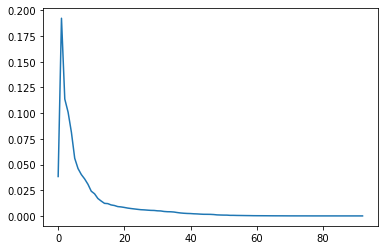

In [47]:
tSVD = decomposition.TruncatedSVD(n_components=len(devs.columns[2:])-1, random_state=888)
devtSVD = tSVD.fit(devsScaled)
comps = devtSVD.components_
compsVariance = devtSVD.explained_variance_
compsVarRatio = devtSVD.explained_variance_ratio_

plt.plot(compsVarRatio)

Although the first component does not explain the most variance, we can pick the first n components because it is one of the components that explain the most. We notice that the variance ratio explained by each component and the distribution is similar to the previous case of PCA.

In [48]:
# Pick components that account for x% of variability
cumSum = 0
nComps = 0
x = 0.75
for varExplained in compsVarRatio:
  cumSum += varExplained
  if cumSum >= x:
    break
  else:
    nComps += 1
print(nComps)

10


Again, the sum of variance ratio explained by the first n components is very similar to the case of PCA. We want to see, though, if the linear relations between components and original features are different. First, find an appropiate number of clusters:

# 3.1. Clustering over tSVD Principal Components.

Again, let us find an appropiate number of clusters over the data projected onto the tSVD PCs.


In [49]:
# project and select the first 10 coordinates.
importantDims = tSVD.transform(devsScaled)[:,:10]

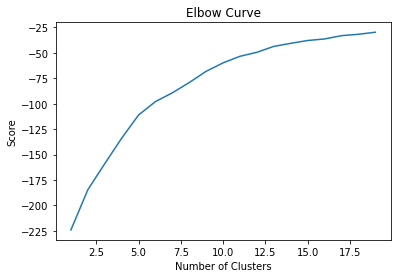

In [50]:
Nc = range(1, 20)
kmeans = [cluster.KMeans(n_clusters=i) for i in Nc]
kmeans
score = [kmeans[i].fit(importantDims).score(importantDims) for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

5 or 6 clusters (visually) seem appropiate for the same reason as before.

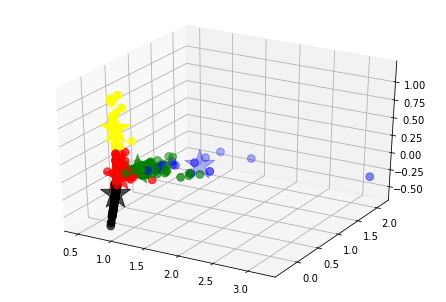

In [51]:
labels, kmeans = fitKMeansAndPlot(importantDims, nClusters=5)

In [52]:
nLabels = dict()
for label in labels:
  if label not in nLabels:
    nLabels[label] = 1
  nLabels[label] += 1 
print(nLabels)

{0: 1951, 1: 239, 2: 15, 3: 35, 4: 225}


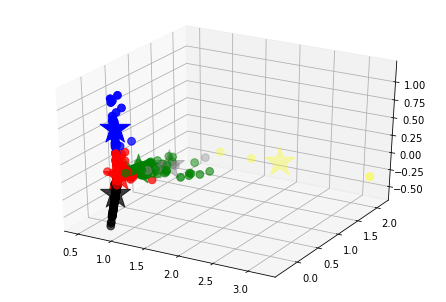

In [53]:
labels, kmeans = fitKMeansAndPlot(importantDims, nClusters=6)

In [54]:
nLabels = dict()
for label in labels:
  if label not in nLabels:
    nLabels[label] = 1
  nLabels[label] += 1 
print(nLabels)

{0: 1953, 1: 241, 3: 4, 5: 8, 2: 35, 4: 225}


The same as in the previous case: a cluster only contains two devs so we pick only 5 clusters.

In [55]:
kmeans = cluster.KMeans(n_clusters=5)
kmeans.fit(importantDims)
centroids = kmeans.cluster_centers_

# 3.2. Interpreting 'tSVD' clusters

Because the PCs extracted from both PCA and tSVD are similarly interpretable, the previously defined functions serve us in the same manner as before to draw conclusions.

Now, we observe the correlation of each centroid with the original features. Note that there is difference with the results obtained from PCA. 

In [56]:
centroids = kmeans.cluster_centers_
corrFeatures, chart = centroid_corr_with_features(centroids[0], devtSVD, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['codeSqaleDebtRatio' '0.067']
 ['codeCommentLinesDensity' '0.065']
 ['codeBlockerViolations' '0.063']
 ['codeBugs' '0.059']
 ['resolutionTime' '0.049']]


alt.Chart(...)

In [57]:
corrFeatures, chart = centroid_corr_with_features(centroids[1], devtSVD, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['codeSqaleDebtRatio' '0.1']
 ['codeBlockerViolations' '0.094']
 ['codeCommentLinesDensity' '0.094']
 ['codeBugs' '0.088']
 ['codeFunctionComplexity' '0.061']]


alt.Chart(...)

In [58]:
corrFeatures, chart = centroid_corr_with_features(centroids[2], devtSVD, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['codeSqaleDebtRatio' '0.072']
 ['codeCommentLinesDensity' '0.07']
 ['codeBlockerViolations' '0.067']
 ['codeBugs' '0.063']
 ['codeFunctionComplexity' '0.045']]


alt.Chart(...)

In [59]:
corrFeatures, chart = centroid_corr_with_features(centroids[3], devtSVD, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['resolutionTime' '0.071']
 ['codeSqaleDebtRatio' '0.044']
 ['codeCommentLinesDensity' '0.044']
 ['codeBlockerViolations' '0.041']
 ['codeBugs' '0.039']]


alt.Chart(...)

In [60]:
corrFeatures, chart = centroid_corr_with_features(centroids[4], devtSVD, devs.columns[2:], 20)
print(corrFeatures[:5])
chart

[['sonarCloseTime' '0.047']
 ['resolutionTime' '0.046']
 ['timeInProject' '0.042']
 ['codeCommentLinesDensity' '0.04']
 ['codeSqaleDebtRatio' '0.037']]


alt.Chart(...)

Finally, we save the same data as before: the mean characteristics of each developer cluster. Note that if there are differences between the two, it does not mean that one of the results is wrong. Rather, it is a different, although correct, clustering obtained from different linear relations (the projection onto the PCA/tSVD Principal Component space).

In [61]:
important_values(centroids[0], devtSVD, devs.columns[2:], minMaxScaler, 10)

[['codeSqaleDebtRatio', 0.0],
 ['codeCommentLinesDensity', 0.01],
 ['codeBlockerViolations', 0.02],
 ['codeBugs', 0.26],
 ['resolutionTime', 36271.81],
 ['codeFunctionComplexity', -0.0],
 ['codeInfoViolations', -0.42],
 ['codeMajorViolations', -5.26],
 ['sonarCloseTime', 21.89],
 ['timeInProject', 4594.22]]

In [62]:
important_values(centroids[1], devtSVD, devs.columns[2:], minMaxScaler, 10)

[['codeSqaleDebtRatio', 0.01],
 ['codeBlockerViolations', 0.08],
 ['codeCommentLinesDensity', -0.01],
 ['codeBugs', -0.19],
 ['codeFunctionComplexity', 0.01],
 ['codeInfoViolations', 1.44],
 ['codeMajorViolations', 12.1],
 ['codeComplexity', 39.89],
 ['codeReliabilityRemediationEffort', 7.9],
 ['codeFunctions', 22.91]]

In [63]:
important_values(centroids[2], devtSVD, devs.columns[2:], minMaxScaler, 10)

[['codeSqaleDebtRatio', 0.56],
 ['codeCommentLinesDensity', 0.12],
 ['codeBlockerViolations', 4.88],
 ['codeBugs', 17.44],
 ['codeFunctionComplexity', 0.32],
 ['sonarCloseTime', 44421.04],
 ['timeInProject', 103924825.86],
 ['resolutionTime', -11.56],
 ['codeInfoViolations', 23.71],
 ['codeMajorViolations', 492.61]]

In [64]:
important_values(centroids[3], devtSVD, devs.columns[2:], minMaxScaler, 10)

[['resolutionTime', 1332.37],
 ['codeSqaleDebtRatio', 0.0],
 ['codeCommentLinesDensity', 0.01],
 ['codeBlockerViolations', 0.01],
 ['codeBugs', 0.07],
 ['fixedJiraIssues', 645.56],
 ['codeFunctionComplexity', -0.0],
 ['jiraMinor', 40.56],
 ['jiraCritical', 127.87],
 ['jiraBlocker', 45.42]]

In [65]:
important_values(centroids[4], devtSVD, devs.columns[2:], minMaxScaler, 10)

[['sonarCloseTime', 27218.9],
 ['resolutionTime', 34.34],
 ['timeInProject', 195534872.87],
 ['codeCommentLinesDensity', -0.19],
 ['codeSqaleDebtRatio', 4.57],
 ['codeBlockerViolations', 52.62],
 ['codeBugs', 251.71],
 ['codeFunctionComplexity', 2.71],
 ['numberCommits', 2169.52],
 ['refactoringExtractMethod', 133.89]]

In [66]:
clusterProfiles = []
for i in range(len(centroids)):
  clusterValues = np.array(important_values(centroids[i], devtSVD, devs.columns[2:], minMaxScaler))
  clusterDf = pd.DataFrame(data=[clusterValues[:,1]], columns=clusterValues[:,0], index=['cluster'+str(i)])
  clusterProfiles.append(clusterDf)
clusterProfilesDf = pd.concat(clusterProfiles)
clusterProfilesDf

,codeSqaleDebtRatio,codeCommentLinesDensity,codeBlockerViolations,codeBugs,resolutionTime,codeFunctionComplexity,codeInfoViolations,codeMajorViolations,sonarCloseTime,timeInProject,...,sonarBug,sonarCritical,sonarInfo,linesRemoved,sonarVulnerability,commitChangeRename,sonarBlocker,commitChangeDelete,jiraDependencyUpgrade,commitChangeUnknown
cluster0,0.0,0.01,0.02,0.26,36271.81,-0.0,-0.42,-5.26,21.89,4594.22,...,0.38,2.59,1.14,-1.28,1.27,-0.03,0.53,-0.04,-0.0,-0.02
cluster1,0.01,-0.01,0.08,-0.19,2735.62,0.01,1.44,12.1,881.42,6829819.48,...,0.16,-0.37,-1.19,4.35,-0.79,0.13,-0.81,0.15,-0.0,0.07
cluster2,0.56,0.12,4.88,17.44,-11.56,0.32,23.71,492.61,44421.04,103924825.86,...,37.06,216.08,60.02,17.0,92.37,0.5,27.08,0.45,0.0,0.02
cluster3,0.0,0.01,0.01,0.07,1332.37,-0.0,-0.73,-2.93,2326.58,8100296.39,...,1.42,11.61,3.76,2.45,5.28,0.0,1.97,-0.05,0.0,-0.05
cluster4,4.57,-0.19,52.62,251.71,34.34,2.71,257.16,6136.34,27218.9,195534872.87,...,630.61,4413.41,1416.34,12.75,1904.19,0.87,703.24,0.66,0.0,-0.01


The same note as in the case of PCA applies here in terms of the negative values of some features after the inverse transform of the centroid.

In [67]:
clusterProfilesDf.to_csv('../../data/interim/Modelling/clusterProfilesTSVD.csv')

See next section 'Evaluation' for a detailed explanation of the meaning of each obtained cluster.

## Extra: comparing aggregated clusters vs. raw clusters

After validating the results, we conclude that three of the 5 clusters extracted in this part are, in practice, very similar to each other. Because of this, we have grouped them into 1 single cluster, thus having 3 clusters in total. Now, we would like to check if extracting directly three clusters from the original data gives us similar profiles as the ones extracted from aggregating 5 clusters.

In [68]:
kmeans = cluster.KMeans(n_clusters=3)
kmeans.fit(importantDims)
centroids = kmeans.cluster_centers_

In [69]:
clusterProfiles = []
for i in range(len(centroids)):
  clusterValues = np.array(important_values(centroids[i], devtSVD, devs.columns[2:], minMaxScaler))
  clusterDf = pd.DataFrame(data=[clusterValues[:,1]], columns=clusterValues[:,0], index=['cluster'+str(i)])
  clusterProfiles.append(clusterDf)
clusterProfilesDf = pd.concat(clusterProfiles)
clusterProfilesDf

,codeSqaleDebtRatio,codeCommentLinesDensity,codeBlockerViolations,codeBugs,codeFunctionComplexity,sonarCloseTime,timeInProject,resolutionTime,codeInfoViolations,codeMajorViolations,...,sonarBlocker,commitChangeRename,linesRemoved,jiraDocumentation,jiraTechnicalTask,jiraStory,commitChangeDelete,jiraQuestion,jiraDependencyUpgrade,commitChangeUnknown
cluster0,0.57,0.11,6.17,20.06,0.34,43388.31,103872397.82,-3.98,25.07,561.07,...,63.76,0.49,16.84,-0.0,-0.01,-0.01,0.44,-0.0,-0.0,0.02
cluster1,4.68,-0.2,30.93,221.32,2.45,30980.04,197034803.66,-2.42,253.63,5353.44,...,49.82,1.02,11.94,0.0,0.01,0.0,0.72,-0.0,0.0,-0.02
cluster2,0.01,-0.01,0.07,-0.12,0.01,757.55,5926980.48,6135.12,1.22,10.29,...,-0.66,0.12,3.73,0.01,0.06,0.17,0.12,0.0,-0.0,0.06


In [70]:
clusterProfilesDf.to_csv('../../data/interim/Modelling/3clusterProfilesTSVD.csv')